In [32]:
import tensorflow as tf
import os
import pandas as pd
import numpy as np

1. Load in the csv file. 

In [33]:
df = pd.read_csv('aqi_ny.csv')

2. Drop the extra index.

In [34]:
df = df.drop('Unnamed: 0', axis=1)

In [35]:
df

,date,co,no,no2,o3,so2,pm2_5,pm10,nh3,aqi,latitude,longitude,city
0,2020-12-01 05:00:00,373.84,1.50,43.87,8.49,6.86,9.31,11.75,1.30,2,40.7127,-74.006,"New York, NY"
1,2020-12-01 06:00:00,343.80,1.16,37.70,9.39,7.09,8.43,10.47,1.09,1,40.7127,-74.006,"New York, NY"
2,2020-12-01 07:00:00,337.12,1.79,35.99,6.35,7.21,8.55,10.80,1.08,1,40.7127,-74.006,"New York, NY"
3,2020-12-01 08:00:00,337.12,3.38,34.96,3.09,7.63,8.92,11.57,1.08,1,40.7127,-74.006,"New York, NY"
4,2020-12-01 09:00:00,340.46,5.87,33.59,1.16,8.23,9.62,12.64,1.09,1,40.7127,-74.006,"New York, NY"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18056,2022-12-31 13:00:00,821.11,62.58,61.69,0.00,5.48,36.08,44.15,3.39,3,40.7127,-74.006,"New York, NY"
18057,2022-12-31 14:00:00,1028.06,92.09,69.23,0.12,6.56,45.75,56.04,3.96,3,40.7127,-74.006,"New York, NY"
18058,2022-12-31 15:00:00,1134.87,104.61,69.23,0.46,8.11,50.21,61.68,4.12,4,40.7127,-74.006,"New York, NY"
18059,2022-12-31 16:00:00,1121.52,101.92,64.43,0.44,9.42,48.14,59.03,4.18,3,40.7127,-74.006,"New York, NY"


3. Make the date column the index, and get rid of extra date column so there's not a duplicate.

In [36]:
df.index = pd.to_datetime(df['date'])

In [37]:
df = df.drop('date', axis=1)

In [38]:
pm25 = df['pm2_5']

4. Visualize your data. 

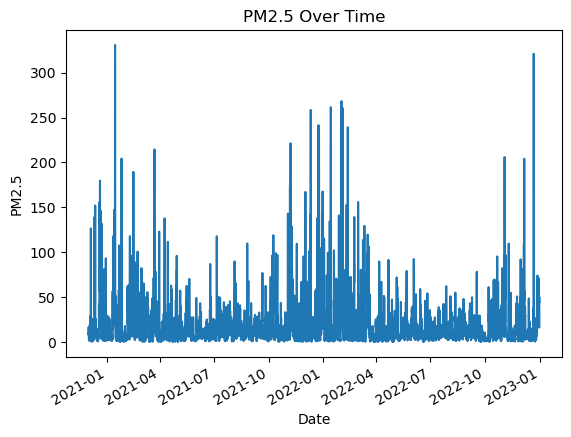

In [124]:
pm25.plot(title= 'PM2.5 Over Time', ylabel = 'PM2.5', xlabel = 'Date');

6. What makes LSTM much better at predicting time series data is that it takes into account a certain amount of values to predict the next one. In this case, the window size is 5, so it is looking at the first 5 values to predict value number 6, next it uses values 2 to 6 to predict 7, and so on. This function gets the data into this format, where X are the predictor values and y is what is being predicted. 

In [40]:
def df_to_X_y(df, window_size=5):
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np)-window_size):
        row = [[a] for a in df_as_np[i:i+5]]
        X.append(row)
        label = df_as_np[i+5]
        y.append(label)
    return np.array(X), np.array(y)

7. This shows us the shape of X and y, for both there are 18056 arrays, but X has 5 values since our window size is 5, and y only has one since we are predicting one value at a time. 

In [41]:
window_size = 5
X, y = df_to_X_y(pm25, window_size)
X.shape, y.shape

((18056, 5, 1), (18056,))

8. Split the data into a training set, a validation set, and a testing set. 

In [42]:
X_train, y_train = X[:12000], y[:12000]
X_val, y_val = X[12000:15000], y[12000:15000]
X_test, y_test = X[15000:], y[15000:]
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((12000, 5, 1), (12000,), (3000, 5, 1), (3000,), (3056, 5, 1), (3056,))

In [43]:
from keras.models import Sequential
from keras.layers import *
from keras.callbacks import ModelCheckpoint
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.optimizers import Adam 

9. Create the model. For the first layer you have to specify the shape of your model, since the window size is 5 the layer is 5 by 1. Next comes 1 LSTM layer, since LSTM is a neural network you have to specify the number of neurons, 32, 64, 128, and 256 are all common. Two dense layers follow the LSTM layer, the last dense layer is responsible for the regression task, and in this case we specify 1 because we want the output to be 1 predicted value.

In [44]:
model1 = Sequential()
model1.add(InputLayer((5,1)))
model1.add(LSTM(64))
model1.add(Dense(8,'relu'))
model1.add(Dense(1,'linear'))

model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 64)                16896     
                                                                 
 dense_2 (Dense)             (None, 8)                 520       
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17,425
Trainable params: 17,425
Non-trainable params: 0
_________________________________________________________________


10. Create a checkpoint that saves the best performing model. Just like our XGBoost model, we are using a low learning rate so it will be slower. 

In [47]:
cp = ModelCheckpoint('model1/',save_best_only=True)
model1.compile(loss=MeanSquaredError(), optimizer = Adam(learning_rate=0.0001), metrics=RootMeanSquaredError())

11. Fit the model. The number you choose for your epochs specifies how many times you will run through the data, so the larger the number the longer it will take to run. 

In [48]:
model1.fit(X_train,y_train, validation_data=(X_val,y_val), epochs=25, callbacks=[cp])

Epoch 1/25
374/375 [============================>.] - ETA: 0s - loss: 1006.1717 - root_mean_squared_error: 31.7202

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


375/375 [==============================] - 14s 30ms/step - loss: 1003.8320 - root_mean_squared_error: 31.6833 - val_loss: 152.1299 - val_root_mean_squared_error: 12.3341
Epoch 2/25
375/375 [==============================] - ETA: 0s - loss: 860.1983 - root_mean_squared_error: 29.3291

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


375/375 [==============================] - 12s 31ms/step - loss: 860.1983 - root_mean_squared_error: 29.3291 - val_loss: 95.0645 - val_root_mean_squared_error: 9.7501
Epoch 3/25
372/375 [============================>.] - ETA: 0s - loss: 730.7098 - root_mean_squared_error: 27.0316

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


375/375 [==============================] - 12s 31ms/step - loss: 729.0887 - root_mean_squared_error: 27.0016 - val_loss: 60.0565 - val_root_mean_squared_error: 7.7496
Epoch 4/25
366/375 [============================>.] - ETA: 0s - loss: 627.7566 - root_mean_squared_error: 25.0551

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


375/375 [==============================] - 9s 25ms/step - loss: 628.0665 - root_mean_squared_error: 25.0613 - val_loss: 40.3531 - val_root_mean_squared_error: 6.3524
Epoch 5/25
366/375 [============================>.] - ETA: 0s - loss: 554.4827 - root_mean_squared_error: 23.5475

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


375/375 [==============================] - 9s 24ms/step - loss: 548.6354 - root_mean_squared_error: 23.4230 - val_loss: 28.2231 - val_root_mean_squared_error: 5.3125
Epoch 6/25
373/375 [============================>.] - ETA: 0s - loss: 482.1332 - root_mean_squared_error: 21.9575

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


375/375 [==============================] - 12s 31ms/step - loss: 481.2758 - root_mean_squared_error: 21.9380 - val_loss: 20.6149 - val_root_mean_squared_error: 4.5404
Epoch 7/25
374/375 [============================>.] - ETA: 0s - loss: 422.6514 - root_mean_squared_error: 20.5585

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


375/375 [==============================] - 11s 30ms/step - loss: 424.0817 - root_mean_squared_error: 20.5932 - val_loss: 16.2655 - val_root_mean_squared_error: 4.0330
Epoch 8/25
366/375 [============================>.] - ETA: 0s - loss: 373.5888 - root_mean_squared_error: 19.3284

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


375/375 [==============================] - 9s 25ms/step - loss: 374.8065 - root_mean_squared_error: 19.3599 - val_loss: 13.4900 - val_root_mean_squared_error: 3.6729
Epoch 9/25
375/375 [==============================] - ETA: 0s - loss: 332.1367 - root_mean_squared_error: 18.2246

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


375/375 [==============================] - 10s 25ms/step - loss: 332.1367 - root_mean_squared_error: 18.2246 - val_loss: 11.4921 - val_root_mean_squared_error: 3.3900
Epoch 10/25
367/375 [============================>.] - ETA: 0s - loss: 296.5912 - root_mean_squared_error: 17.2218

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


375/375 [==============================] - 9s 24ms/step - loss: 295.1458 - root_mean_squared_error: 17.1798 - val_loss: 9.8807 - val_root_mean_squared_error: 3.1434
Epoch 11/25
367/375 [============================>.] - ETA: 0s - loss: 261.9033 - root_mean_squared_error: 16.1834

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


375/375 [==============================] - 10s 28ms/step - loss: 262.8469 - root_mean_squared_error: 16.2126 - val_loss: 9.0868 - val_root_mean_squared_error: 3.0144
Epoch 12/25
374/375 [============================>.] - ETA: 0s - loss: 234.6256 - root_mean_squared_error: 15.3175

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


375/375 [==============================] - 9s 24ms/step - loss: 234.0363 - root_mean_squared_error: 15.2982 - val_loss: 8.6606 - val_root_mean_squared_error: 2.9429
Epoch 13/25
367/375 [============================>.] - ETA: 0s - loss: 210.9555 - root_mean_squared_error: 14.5243

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


375/375 [==============================] - 9s 25ms/step - loss: 209.2585 - root_mean_squared_error: 14.4658 - val_loss: 8.6045 - val_root_mean_squared_error: 2.9333
Epoch 14/25
371/375 [============================>.] - ETA: 0s - loss: 189.5001 - root_mean_squared_error: 13.7659

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


375/375 [==============================] - 9s 24ms/step - loss: 188.1260 - root_mean_squared_error: 13.7159 - val_loss: 8.2242 - val_root_mean_squared_error: 2.8678
Epoch 15/25
369/375 [============================>.] - ETA: 0s - loss: 164.8115 - root_mean_squared_error: 12.8379

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


375/375 [==============================] - 10s 28ms/step - loss: 170.0815 - root_mean_squared_error: 13.0415 - val_loss: 7.9928 - val_root_mean_squared_error: 2.8272
Epoch 16/25
375/375 [==============================] - 4s 10ms/step - loss: 154.5755 - root_mean_squared_error: 12.4328 - val_loss: 7.9973 - val_root_mean_squared_error: 2.8280
Epoch 17/25
375/375 [==============================] - 3s 7ms/step - loss: 140.8138 - root_mean_squared_error: 11.8665 - val_loss: 8.0807 - val_root_mean_squared_error: 2.8427
Epoch 18/25
375/375 [==============================] - 3s 7ms/step - loss: 128.5649 - root_mean_squared_error: 11.3386 - val_loss: 8.1131 - val_root_mean_squared_error: 2.8483
Epoch 19/25
375/375 [==============================] - ETA: 0s - loss: 117.7773 - root_mean_squared_error: 10.8525

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


375/375 [==============================] - 9s 24ms/step - loss: 117.7773 - root_mean_squared_error: 10.8525 - val_loss: 7.8771 - val_root_mean_squared_error: 2.8066
Epoch 20/25
375/375 [==============================] - 4s 9ms/step - loss: 108.4131 - root_mean_squared_error: 10.4122 - val_loss: 8.5406 - val_root_mean_squared_error: 2.9224
Epoch 21/25
375/375 [==============================] - 3s 8ms/step - loss: 100.2785 - root_mean_squared_error: 10.0139 - val_loss: 8.1682 - val_root_mean_squared_error: 2.8580
Epoch 22/25
375/375 [==============================] - 3s 7ms/step - loss: 93.1704 - root_mean_squared_error: 9.6525 - val_loss: 8.3190 - val_root_mean_squared_error: 2.8843
Epoch 23/25
375/375 [==============================] - 3s 7ms/step - loss: 86.7196 - root_mean_squared_error: 9.3123 - val_loss: 8.4638 - val_root_mean_squared_error: 2.9093
Epoch 24/25
375/375 [==============================] - 3s 7ms/step - loss: 80.8985 - root_mean_squared_error: 8.9944 - val_loss: 8.7125

In [49]:
from keras.models import load_model

12. Loads the model so we can work with the best one. 

In [50]:
model1 = load_model('model1/')

13. Calculate the predicted values for the training set and add them to a dataframe.

In [85]:
train_predictions = model1.predict(X_train).flatten()
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train})
train_results

375/375 [==============================] - 2s 5ms/step


,Train Predictions,Actuals
0,10.307143,10.60
1,11.263230,11.92
2,12.804028,15.04
3,18.041586,16.85
4,16.228193,15.64
...,...,...
11995,2.125412,2.45
11996,3.204007,2.90
11997,3.335415,3.48
11998,4.300287,4.54


14. Visualize the data to compare predicted values to the actual values for the training set. As you can see, the model did a pretty good job of predicting values since the lines are pretty close together, but it seems like it has a harder time predicting the larger spikes like the XGBoost model. 

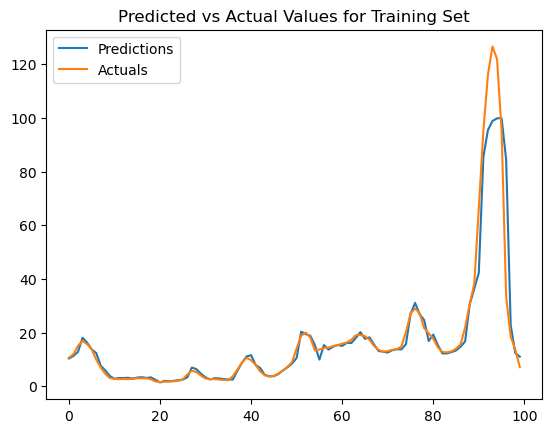

In [116]:
import matplotlib.pyplot as plt
plt.plot(train_results['Train Predictions'][:100])
plt.plot(train_results['Actuals'][:100])
plt.title('Predicted vs Actual Values for Training Set')
plt.legend(['Predictions','Actuals']);

15. Calculate the predicted values for the validation set and add them to a dataframe.

In [87]:
val_predictions = model1.predict(X_val).flatten()
val_results = pd.DataFrame(data={'Val Predictions':val_predictions, 'Actuals':y_val})
val_results

94/94 [==============================] - 0s 5ms/step


,Val Predictions,Actuals
0,7.201717,7.60
1,9.176711,11.78
2,16.913963,12.08
3,9.205516,5.95
4,2.537470,6.47
...,...,...
2995,19.922052,20.61
2996,19.529484,19.86
2997,18.154495,18.63
2998,17.156572,17.85


16. Visualize the data to compare predicted values to the actual values for the validation set. It looks like the model did a better job predicting the large spikes for this set. 

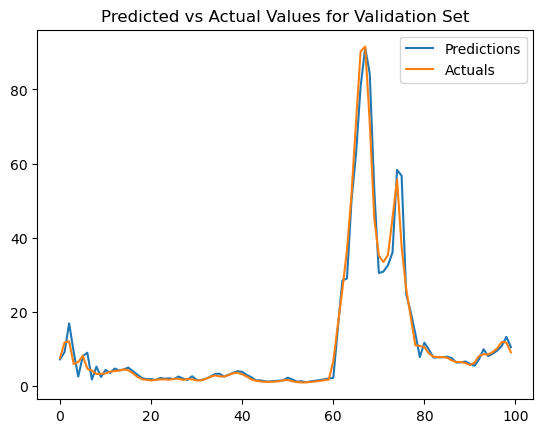

In [117]:
plt.plot(val_results['Val Predictions'][:100])
plt.plot(val_results['Actuals'][:100])
plt.title('Predicted vs Actual Values for Validation Set')
plt.legend(['Predictions','Actuals']);

17. Calculate the predicted values for the test set and add them to a dataframe.

In [89]:
test_predictions = model1.predict(X_test).flatten()
test_results = pd.DataFrame(data={'Test Predictions':test_predictions, 'Actuals':y_test})
test_results

96/96 [==============================] - 0s 4ms/step


,Test Predictions,Actuals
0,18.914171,18.85
1,18.620604,16.84
2,14.394859,17.90
3,20.261818,19.42
4,19.124249,22.37
...,...,...
3051,35.103706,36.08
3052,45.220074,45.75
3053,49.981522,50.21
3054,48.004055,48.14


18. Visualize the data to compare predicted values to the actual values for the test set. This time, it looks like the model overshot the actual values since the predicted line rises above the one for the actuals. 

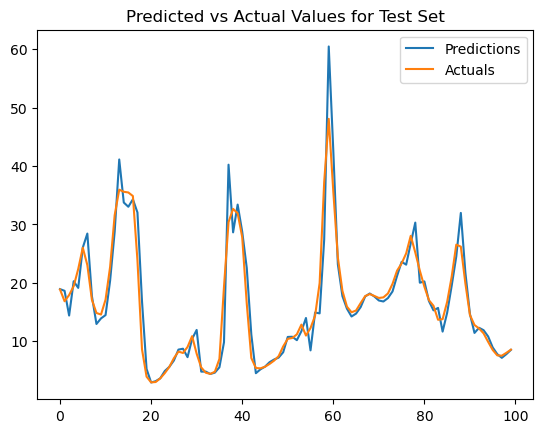

In [118]:
plt.plot(test_results['Test Predictions'][:100])
plt.plot(test_results['Actuals'][:100])
plt.title('Predicted vs Actual Values for Test Set')
plt.legend(['Predictions','Actuals']);

In [57]:
from sklearn.metrics import r2_score

19. Calculate the coefficient of determination for the training set, validation set, and testing set. As you can see, the model performed pretty well when you consider that we did not have to add any extra features like we had to for the XGBoost model. When we tested the XGBoost model's training score with no added features it was .12, so this model performs much better at its most basic level. 

In [106]:
train_r2 = r2_score(train_results['Actuals'],train_results['Train Predictions'])
train_r2

0.8433873002903651

In [60]:
val_r2 = r2_score(val_results['Actuals'],val_results['Val Predictions'])
val_r2

0.9253142207262933

In [105]:
test_r2 = r2_score(test_results['Actuals'],test_results['Test Predictions'])
test_r2

0.7846054986630341

20. Create a second model. This time we are adding features to help it get a better sense of how the data progresses with time so that its performance is improved. As we saw before, this is not as necessary as when you use XGBoost to predict time series data, but we want to refine our model. 

In [62]:
pm25_df = pd.DataFrame({'pm2_5':pm25})
pm25_df['seconds'] = pm25_df.index.map(pd.Timestamp.timestamp)
pm25_df

,pm2_5,seconds
date,,
2020-12-01 05:00:00,9.31,1.606799e+09
2020-12-01 06:00:00,8.43,1.606802e+09
2020-12-01 07:00:00,8.55,1.606806e+09
2020-12-01 08:00:00,8.92,1.606810e+09
2020-12-01 09:00:00,9.62,1.606813e+09
...,...,...
2022-12-31 13:00:00,36.08,1.672492e+09
2022-12-31 14:00:00,45.75,1.672495e+09
2022-12-31 15:00:00,50.21,1.672499e+09


21. Use the seconds column to create columns for Day sin, Day cos, Year sin, and Year cos. These features are similar to the lag features that we used for our XGBoost model in that they are there to give a sense of relative time, but these are referred to as cyclical features. 

In [63]:
day = 60*60*24
year = 365.2425*day 

pm25_df['Day sin'] = np.sin(pm25_df['seconds'] * (2*np.pi / day))
pm25_df['Day cos'] = np.cos(pm25_df['seconds'] * (2*np.pi / day))
pm25_df['Year sin'] = np.sin(pm25_df['seconds'] * (2*np.pi / year))
pm25_df['Year cos'] = np.cos(pm25_df['seconds'] * (2*np.pi / year))

In [64]:
pm25_df

,pm2_5,seconds,Day sin,Day cos,Year sin,Year cos
date,,,,,,
2020-12-01 05:00:00,9.31,1.606799e+09,0.965926,2.588190e-01,-0.495857,0.868404
2020-12-01 06:00:00,8.43,1.606802e+09,1.000000,1.086286e-11,-0.495234,0.868759
2020-12-01 07:00:00,8.55,1.606806e+09,0.965926,-2.588190e-01,-0.494612,0.869114
2020-12-01 08:00:00,8.92,1.606810e+09,0.866025,-5.000000e-01,-0.493988,0.869468
2020-12-01 09:00:00,9.62,1.606813e+09,0.707107,-7.071068e-01,-0.493365,0.869822
...,...,...,...,...,...,...
2022-12-31 13:00:00,36.08,1.672492e+09,-0.258819,-9.659258e-01,-0.005347,0.999986
2022-12-31 14:00:00,45.75,1.672495e+09,-0.500000,-8.660254e-01,-0.004630,0.999989
2022-12-31 15:00:00,50.21,1.672499e+09,-0.707107,-7.071068e-01,-0.003914,0.999992


22. Drop the seconds column since it is no longer necessary now that we have created the extra columns. 

In [65]:
aqi_df = pm25_df.drop('seconds', axis=1)

In [66]:
aqi_df

,pm2_5,Day sin,Day cos,Year sin,Year cos
date,,,,,
2020-12-01 05:00:00,9.31,0.965926,2.588190e-01,-0.495857,0.868404
2020-12-01 06:00:00,8.43,1.000000,1.086286e-11,-0.495234,0.868759
2020-12-01 07:00:00,8.55,0.965926,-2.588190e-01,-0.494612,0.869114
2020-12-01 08:00:00,8.92,0.866025,-5.000000e-01,-0.493988,0.869468
2020-12-01 09:00:00,9.62,0.707107,-7.071068e-01,-0.493365,0.869822
...,...,...,...,...,...
2022-12-31 13:00:00,36.08,-0.258819,-9.659258e-01,-0.005347,0.999986
2022-12-31 14:00:00,45.75,-0.500000,-8.660254e-01,-0.004630,0.999989
2022-12-31 15:00:00,50.21,-0.707107,-7.071068e-01,-0.003914,0.999992


23. This is the same function as before, but it makes it so that there are 6 lists in each array since the window size is 6, and each array has 5 values since we have 5 features now (PM2.5, day sin, day cos, year sin, and year cos).

In [67]:
def df_to_X_y2(df, window_size=6):
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np)-window_size):
        row = [r for r in df_as_np[i:i+window_size]]
        X.append(row)
        label = df_as_np[i+window_size][0]
        y.append(label)
    return np.array(X), np.array(y)

In [68]:
X2, y2 = df_to_X_y2(aqi_df)
X2.shape, y2.shape 

((18055, 6, 5), (18055,))

24. Separate the data into a training set, a validation set, and a testing set. 

In [69]:
X2_train, y2_train = X2[:12000], y2[:12000]
X2_val, y2_val = X2[12000:15000], y2[12000:15000]
X2_test, y2_test = X2[15000:], y2[15000:]
X2_train.shape, y2_train.shape, X2_val.shape, y2_val.shape, X2_test.shape, y2_test.shape

((12000, 6, 5), (12000,), (3000, 6, 5), (3000,), (3055, 6, 5), (3055,))

25. Standardize the data so that all the values are on a similar scale. 

In [70]:
pm25_training_mean = np.mean(X2_train[:, :, 0])
pm25_training_std = np.std(X2_train[:, :, 0])

def preprocess(X):
    X[:, :, 0] = (X[:, :, 0] - pm25_training_mean) / pm25_training_std
    return X

In [71]:
preprocess(X2_train)
preprocess(X2_val)
preprocess(X2_test)

array([[[ 7.62945550e-02,  9.65925826e-01,  2.58819045e-01,
         -7.79677220e-01, -6.26181629e-01],
        [ 4.83445857e-02,  1.00000000e+00,  9.43975630e-12,
         -7.80125855e-01, -6.25622610e-01],
        [ 2.50663606e-03,  9.65925826e-01, -2.58819045e-01,
         -7.80574090e-01, -6.25063269e-01],
        [-2.65613320e-02,  8.66025404e-01, -5.00000000e-01,
         -7.81021924e-01, -6.24503606e-01],
        [-7.55535289e-03,  7.07106781e-01, -7.07106781e-01,
         -7.81469356e-01, -6.23943623e-01],
        [ 1.07052937e-02,  5.00000000e-01, -8.66025404e-01,
         -7.81916387e-01, -6.23383320e-01]],

       [[ 4.83445857e-02,  1.00000000e+00,  9.43975630e-12,
         -7.80125855e-01, -6.25622610e-01],
        [ 2.50663606e-03,  9.65925826e-01, -2.58819045e-01,
         -7.80574090e-01, -6.25063269e-01],
        [-2.65613320e-02,  8.66025404e-01, -5.00000000e-01,
         -7.81021924e-01, -6.24503606e-01],
        [-7.55535289e-03,  7.07106781e-01, -7.07106781e-01,
  

26. Create the model, everything stays the same as the first attempt but the InputLayer since the dimensions have now changed because we added those extra time features. 

In [72]:
model2 = Sequential()
model2.add(InputLayer((6, 5)))
model2.add(LSTM(64))
model2.add(Dense(8,'relu'))
model2.add(Dense(1,'linear'))

model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 64)                17920     
                                                                 
 dense_4 (Dense)             (None, 8)                 520       
                                                                 
 dense_5 (Dense)             (None, 1)                 9         
                                                                 
Total params: 18,449
Trainable params: 18,449
Non-trainable params: 0
_________________________________________________________________


27. Create the checkpoint to save the best model.

In [73]:
cp2 = ModelCheckpoint('model2/',save_best_only=True)
model2.compile(loss=MeanSquaredError(), optimizer = Adam(learning_rate=0.0001), metrics=RootMeanSquaredError())

28. Fit the model.

In [74]:
model2.fit(X2_train,y2_train, validation_data=(X2_val,y2_val), epochs=25, callbacks=[cp2])

Epoch 1/25
375/375 [==============================] - ETA: 0s - loss: 1000.5403 - root_mean_squared_error: 31.6313

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


375/375 [==============================] - 15s 34ms/step - loss: 1000.5403 - root_mean_squared_error: 31.6313 - val_loss: 218.0472 - val_root_mean_squared_error: 14.7664
Epoch 2/25
374/375 [============================>.] - ETA: 0s - loss: 692.2092 - root_mean_squared_error: 26.3099

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


375/375 [==============================] - 14s 36ms/step - loss: 690.6404 - root_mean_squared_error: 26.2800 - val_loss: 77.2995 - val_root_mean_squared_error: 8.7920
Epoch 3/25
374/375 [============================>.] - ETA: 0s - loss: 561.5595 - root_mean_squared_error: 23.6972

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


375/375 [==============================] - 13s 35ms/step - loss: 560.4183 - root_mean_squared_error: 23.6732 - val_loss: 71.5503 - val_root_mean_squared_error: 8.4587
Epoch 4/25
373/375 [============================>.] - ETA: 0s - loss: 510.7245 - root_mean_squared_error: 22.5992

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


375/375 [==============================] - 12s 31ms/step - loss: 510.8038 - root_mean_squared_error: 22.6010 - val_loss: 68.7395 - val_root_mean_squared_error: 8.2909
Epoch 5/25
372/375 [============================>.] - ETA: 0s - loss: 460.7281 - root_mean_squared_error: 21.4646

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


375/375 [==============================] - 11s 29ms/step - loss: 459.5604 - root_mean_squared_error: 21.4374 - val_loss: 62.3068 - val_root_mean_squared_error: 7.8935
Epoch 6/25
370/375 [============================>.] - ETA: 0s - loss: 403.3626 - root_mean_squared_error: 20.0839

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


375/375 [==============================] - 10s 28ms/step - loss: 403.7286 - root_mean_squared_error: 20.0930 - val_loss: 53.2663 - val_root_mean_squared_error: 7.2984
Epoch 7/25
375/375 [==============================] - ETA: 0s - loss: 354.1808 - root_mean_squared_error: 18.8197

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


375/375 [==============================] - 11s 30ms/step - loss: 354.1808 - root_mean_squared_error: 18.8197 - val_loss: 44.0272 - val_root_mean_squared_error: 6.6353
Epoch 8/25
370/375 [============================>.] - ETA: 0s - loss: 308.9828 - root_mean_squared_error: 17.5779

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


375/375 [==============================] - 10s 27ms/step - loss: 309.5748 - root_mean_squared_error: 17.5947 - val_loss: 36.0436 - val_root_mean_squared_error: 6.0036
Epoch 9/25
373/375 [============================>.] - ETA: 0s - loss: 269.7136 - root_mean_squared_error: 16.4230

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


375/375 [==============================] - 10s 26ms/step - loss: 272.4788 - root_mean_squared_error: 16.5069 - val_loss: 32.8953 - val_root_mean_squared_error: 5.7354
Epoch 10/25
374/375 [============================>.] - ETA: 0s - loss: 241.8763 - root_mean_squared_error: 15.5524

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


375/375 [==============================] - 10s 25ms/step - loss: 241.3996 - root_mean_squared_error: 15.5370 - val_loss: 29.0213 - val_root_mean_squared_error: 5.3871
Epoch 11/25
372/375 [============================>.] - ETA: 0s - loss: 215.3001 - root_mean_squared_error: 14.6731

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


375/375 [==============================] - 11s 28ms/step - loss: 214.6852 - root_mean_squared_error: 14.6521 - val_loss: 25.6808 - val_root_mean_squared_error: 5.0676
Epoch 12/25
374/375 [============================>.] - ETA: 0s - loss: 191.4399 - root_mean_squared_error: 13.8362

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


375/375 [==============================] - 10s 27ms/step - loss: 191.1861 - root_mean_squared_error: 13.8270 - val_loss: 23.2371 - val_root_mean_squared_error: 4.8205
Epoch 13/25
371/375 [============================>.] - ETA: 0s - loss: 172.2566 - root_mean_squared_error: 13.1247

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


375/375 [==============================] - 12s 32ms/step - loss: 170.6743 - root_mean_squared_error: 13.0642 - val_loss: 20.9768 - val_root_mean_squared_error: 4.5800
Epoch 14/25
373/375 [============================>.] - ETA: 0s - loss: 153.4664 - root_mean_squared_error: 12.3882

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


375/375 [==============================] - 10s 27ms/step - loss: 153.0406 - root_mean_squared_error: 12.3710 - val_loss: 18.3449 - val_root_mean_squared_error: 4.2831
Epoch 15/25
370/375 [============================>.] - ETA: 0s - loss: 138.0838 - root_mean_squared_error: 11.7509

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


375/375 [==============================] - 11s 29ms/step - loss: 137.6947 - root_mean_squared_error: 11.7343 - val_loss: 17.1902 - val_root_mean_squared_error: 4.1461
Epoch 16/25
373/375 [============================>.] - ETA: 0s - loss: 125.3002 - root_mean_squared_error: 11.1938

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


375/375 [==============================] - 11s 29ms/step - loss: 124.7635 - root_mean_squared_error: 11.1698 - val_loss: 15.6085 - val_root_mean_squared_error: 3.9508
Epoch 17/25
375/375 [==============================] - ETA: 0s - loss: 113.5685 - root_mean_squared_error: 10.6569

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


375/375 [==============================] - 9s 25ms/step - loss: 113.5685 - root_mean_squared_error: 10.6569 - val_loss: 14.0456 - val_root_mean_squared_error: 3.7477
Epoch 18/25
371/375 [============================>.] - ETA: 0s - loss: 103.1640 - root_mean_squared_error: 10.1570

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


375/375 [==============================] - 10s 26ms/step - loss: 103.6865 - root_mean_squared_error: 10.1827 - val_loss: 13.2449 - val_root_mean_squared_error: 3.6394
Epoch 19/25
375/375 [==============================] - ETA: 0s - loss: 95.0821 - root_mean_squared_error: 9.7510

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


375/375 [==============================] - 11s 30ms/step - loss: 95.0821 - root_mean_squared_error: 9.7510 - val_loss: 12.2037 - val_root_mean_squared_error: 3.4934
Epoch 20/25
374/375 [============================>.] - ETA: 0s - loss: 87.3848 - root_mean_squared_error: 9.3480

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


375/375 [==============================] - 11s 30ms/step - loss: 87.2461 - root_mean_squared_error: 9.3406 - val_loss: 11.5996 - val_root_mean_squared_error: 3.4058
Epoch 21/25
373/375 [============================>.] - ETA: 0s - loss: 80.9033 - root_mean_squared_error: 8.9946

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


375/375 [==============================] - 13s 33ms/step - loss: 80.5368 - root_mean_squared_error: 8.9742 - val_loss: 10.7794 - val_root_mean_squared_error: 3.2832
Epoch 22/25
374/375 [============================>.] - ETA: 0s - loss: 74.5836 - root_mean_squared_error: 8.6362

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


375/375 [==============================] - 10s 27ms/step - loss: 74.4546 - root_mean_squared_error: 8.6287 - val_loss: 10.3978 - val_root_mean_squared_error: 3.2246
Epoch 23/25
371/375 [============================>.] - ETA: 0s - loss: 66.9194 - root_mean_squared_error: 8.1804

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


375/375 [==============================] - 14s 37ms/step - loss: 69.0382 - root_mean_squared_error: 8.3089 - val_loss: 9.8205 - val_root_mean_squared_error: 3.1338
Epoch 24/25
375/375 [==============================] - ETA: 0s - loss: 64.1823 - root_mean_squared_error: 8.0114

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


375/375 [==============================] - 14s 38ms/step - loss: 64.1823 - root_mean_squared_error: 8.0114 - val_loss: 9.6870 - val_root_mean_squared_error: 3.1124
Epoch 25/25
373/375 [============================>.] - ETA: 0s - loss: 60.0994 - root_mean_squared_error: 7.7524

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


375/375 [==============================] - 15s 39ms/step - loss: 59.9543 - root_mean_squared_error: 7.7430 - val_loss: 9.2483 - val_root_mean_squared_error: 3.0411


29. Load the model so we can work with the best one. 

In [75]:
model2 = load_model('model2/')

30. Calculate the predicted values for the training set and add them to a dataframe.

In [93]:
train_predictions2 = model2.predict(X2_train).flatten()
train_results2 = pd.DataFrame(data={'Train Predictions': train_predictions2, 'Actuals': y2_train})
train_results2

375/375 [==============================] - 2s 6ms/step


,Train Predictions,Actuals
0,12.791660,11.92
1,14.384006,15.04
2,17.879391,16.85
3,18.592781,15.64
4,14.360879,13.76
...,...,...
11995,1.983546,2.90
11996,2.534888,3.48
11997,3.313388,4.54
11998,4.610144,5.91


31. Visualize the data to compare predicted values to the actual values for the training set. Again, the model did a pretty good job of predicting values since the lines are pretty close together, but it seems like it has a harder time predicting the large spikes like the last model. 

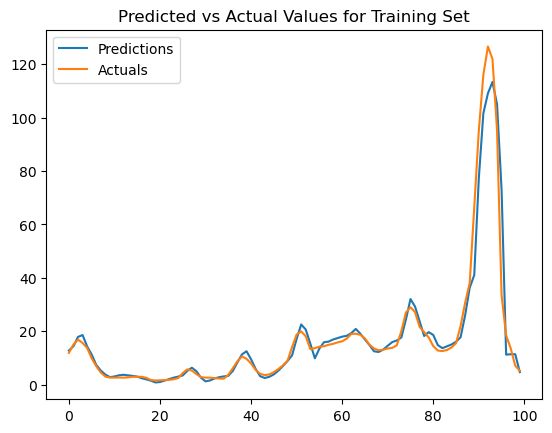

In [119]:
plt.plot(train_results2['Train Predictions'][:100])
plt.plot(train_results2['Actuals'][:100])
plt.title('Predicted vs Actual Values for Training Set')
plt.legend(['Predictions','Actuals']);

32. Calculate the predicted values for the validation set and add them to a dataframe.

In [95]:
val_predictions2 = model2.predict(X2_val).flatten()
val_results2 = pd.DataFrame(data={'Val Predictions': val_predictions2, 'Actuals': y2_val})
val_results2

94/94 [==============================] - 1s 7ms/step


,Val Predictions,Actuals
0,8.225341,11.78
1,13.063285,12.08
2,12.988453,5.95
3,3.729063,6.47
4,4.601079,8.21
...,...,...
2995,18.989849,19.86
2996,18.208073,18.63
2997,17.746162,17.85
2998,18.107964,18.36


33. Visualize the data to compare predicted values to the actual values for the validation set. For this set, it looks like the model did better at predicting those larger spikes.

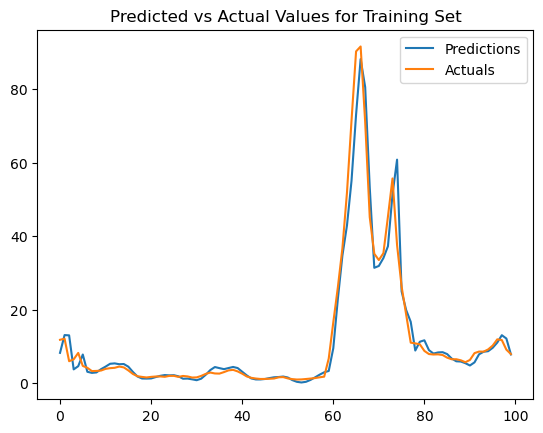

In [120]:
plt.plot(val_results2['Val Predictions'][:100])
plt.plot(val_results2['Actuals'][:100])
plt.title('Predicted vs Actual Values for Training Set')
plt.legend(['Predictions','Actuals']);

34. Calculate the predicted values for the training set and add them to a dataframe.

In [97]:
test_predictions2 = model2.predict(X2_test).flatten()
test_results2 = pd.DataFrame(data={'Test Predictions': test_predictions2, 'Actuals': y2_test})
test_results2

96/96 [==============================] - 1s 6ms/step


,Test Predictions,Actuals
0,20.650051,16.84
1,17.231438,17.90
2,18.282816,19.42
3,19.691925,22.37
4,22.577848,26.01
...,...,...
3050,30.946255,36.08
3051,44.017494,45.75
3052,49.690575,50.21
3053,48.047276,48.14


35. Visualize the data to compare predicted values to the actual values for the testing set. For this set, it looks like the model  overshot the actuals for the larger spikes.

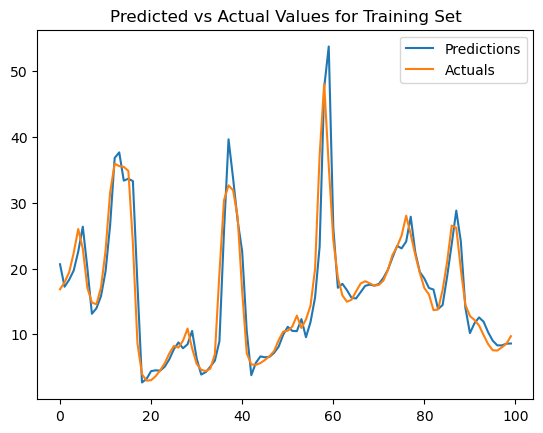

In [121]:
plt.plot(test_results2['Test Predictions'][:100])
plt.plot(test_results2['Actuals'][:100])
plt.title('Predicted vs Actual Values for Training Set')
plt.legend(['Predictions','Actuals']);

36. Calculate the coefficient of determination for the training set, validation set, and testing set. As you can see, the model performed better on the training and testing sets when compared to the last model. Those values were .84 and .78 respectively, and now they are .91 and .88. Overall, the performance of this second model is better than the last one because of the added cycical features. 

In [101]:
train2_r2 = r2_score(train_results2['Actuals'],train_results2['Train Predictions'])
train2_r2

0.9197300500784565

In [102]:
val2_r2 = r2_score(val_results2['Actuals'],val_results2['Val Predictions'])
val2_r2

0.9123240028463745

In [104]:
test2_r2 = r2_score(test_results2['Actuals'],test_results2['Test Predictions'])
test2_r2

0.8882776817240181